In [16]:
struct GAStrategy
    selection
    selection_ratio::Real
    crossover
    crossover_prob::Real
    mutation
    mutation_σ::Real
    mutation_prob::Real
    error_tolerance::Real
    max_iter::Integer
end

In [17]:
# Algoritmo Genérico
struct GA
    f::Function
    LI::Array{<:Number}
    LS::Array{<:Number}
    g::Function
    h::Function
    strategy::GAStrategy
end

In [18]:
grayencode(n::Integer) = n ⊻ (n >> 1)

function graydecode(n::Integer)
    r = n
    while (n >>= 1) != 0
        r ⊻= n
    end
    return r
end

function bitarr_to_int(arr, val = 0)
    v = 2^(length(arr)-1)
    for i in eachindex(arr)
        val += v*arr[i]
        v >>= 1
    end
    return val
end


bitarr_to_int (generic function with 2 methods)

In [19]:
evaluate_f(ga::GA, X::Vector{<:Any}) = ga.f.(X)

evaluate_f (generic function with 1 method)

In [2]:
using HTTP
res = HTTP.get("https://httpbin.org/anything")

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Date: Sun, 28 Nov 2021 14:16:49 GMT
Content-Type: application/json
Content-Length: 374
Connection: keep-alive
Server: gunicorn/19.9.0
Access-Control-Allow-Origin: *
Access-Control-Allow-Credentials: true

{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {}, 
  "headers": {
    "Accept": "*/*", 
    "Content-Length": "0", 
    "Host": "httpbin.org", 
    "User-Agent": "HTTP.jl/1.6.1", 
    "X-Amzn-Trace-Id": "Root=1-61a38f51-22e982222cf8aa8b060e308c"
  }, 
  "json": null, 
  "method": "GET", 
  "origin": "201.17.158.253", 
  "url": "https://httpbin.org/anything"
}
"""

In [20]:
function rand_X(ga::GA, D::Integer, N::Integer, T=Float64)
    X = Vector{Vector{T}}(undef, N)
    for i in 1:N
        if T <: AbstractFloat
            v = ga.LI .+ rand(T, D).*(ga.LS.-ga.LI)
        else
            v = trunc.(T, ga.LI .+ rand(D).*(ga.LS.-ga.LI))
        end
        X[i] = v
    end
    X
end

rand_X (generic function with 2 methods)

In [34]:
function bitarray_to_int(ga, ba::BitArray)
    l = length(ba)
    k = sum(ba .* (2 .^ (l-1:-1:0)))
    ga.LI + (ga.LS - ga.LI)*k/(2^l - 1)
end

function int_to_bitarray(ga, x::Integer)
    parse.(Bool, split(bitstring(x), ""))
end

int_to_bitarray (generic function with 1 method)

In [35]:
# crossover aritimético total
function reproduction(ga::GA, XA::Vector{<:Real}, XB::Vector{<:Real})
    if rand() < ga.strategy.crossover_prob
        childA, childB = Float64[], Float64[]
        for (a, b) in zip(XA, XB) 
            α = rand()
            push!(childA, a*α + b*(1-α))
            push!(childB, b*α + a*(1-α))
        end
    else
        childA, childB = XA, XB
    end
    childA, childB
end

reproduction (generic function with 1 method)

In [36]:
# bitflip
function reproduction(ga::GA, XA::Vector{<:Integer}, XB::Vector{<:Integer})
    if rand() < ga.strategy.crossover_prob
        childA, childB = Integer[], Integer[]
        for (a, b) in zip(XA, XB)
            r = rand(typeof(a))
            newgenA = (~r & grayencode(a)) | (r & grayencode(b))
            newgenB = (~r & grayencode(b)) | (r & grayencode(a))
            push!(childA, graydecode(newgenA))
            push!(childB, graydecode(newgenB))
        end
    else
        childA, childB = XA, XB
    end
    childA, childB
end

reproduction (generic function with 2 methods)

In [37]:
using Random, Distributions

function mutate!(ga::GA, X::Vector{<:Real}, age=0)
    D = length(X)
    
    if rand() < ga.strategy.mutation_prob
        
        X += rand(Normal(0, ga.strategy.mutation_σ*(1-age)), D)

        for i in 1:D
            if X[i] < ga.LI[i]
                X[i] = ga.LI[i]
            elseif X[i] > ga.LS[i]
                X[i] = ga.LS[i]
            end
        end
    end
    X
end

function mutate!(ga::GA, X::Vector{<:Integer}, age=0)
    D = length(X)
    T = typeof(X[1])
    
#     if rand() > ga.strategy.mutation_prob
        for i in 1:D
        
            Δ = trunc(T, ga.LS[i] - ga.LI[i])
        
            x = X[i] + Δ
            
            flip_arr = [0; rand(ndigits(typemin(Int8), base=2)-1) .< ga.strategy.mutation_prob]
            flip = bitarr_to_int(flip_arr)
            
            x = graydecode(grayencode(x) ⊻ trunc(T, flip))
            
            X[i] = x - Δ
        
            if X[i] < ga.LI[i]
                X[i] = ga.LI[i]
            elseif X[i] > ga.LS[i]
                X[i] = ga.LS[i]
            end
        end
#     end
    X
end

mutate! (generic function with 4 methods)

In [38]:
mutate!(ga, [-10])

LoadError: UndefVarError: ga not defined

In [39]:
function selection(ga::GA, X::Vector{<:Any}, fitness::Vector{<:Real}, age=0)
    N = length(X)
    
    s = ga.strategy
    idx = sortperm(fitness, rev=true)
    
    X = X[idx]
    
    if s.selection == :reducebyage
        j = Integer(ceil(N * (s.selection_ratio*(1-age))))
    else
        j = Integer(ceil(N * (s.selection_ratio)))
    end
    j = j <= 1 ? 2 : j
    
    @view X[1:j]
end


selection (generic function with 2 methods)

In [40]:
using IterTools
using Combinatorics

function evolve_gen(ga::GA, X::Vector{<:Any}, fitness::Vector{<:Real}, age=0)
    N = length(X)
    D = length(X[1])
    s = ga.strategy
    
    Xred = selection(ga, X, fitness, age)
    
    comb = collect(combinations(1:length(Xred), 2))
    
    newX = typeof(X)()
    i = 0
    while i < N
        comb = shuffle(comb)
        for k in 1:length(comb)
            if i >= N
                break
            end
            a, b = comb[k]
            childA, childB = reproduction(ga, Xred[a], Xred[b])
            push!(newX, childA)
            push!(newX, childB)
            i += 2
        end
    end
    
    for i in 1:N
        newX[i] = mutate!(ga, newX[i], age)
    end
    
    newX
end

evolve_gen (generic function with 2 methods)

In [41]:
using Statistics

function run(ga::GA, XO::Vector{<:Any}, objective=:max)

    sig = objective == :max ? 1 : -1
    
    fitness0 = evaluate_f(ga, X0) .* sig
    new_Xs = X0
    fitness = fitness0
    
    i = 1
#     e = ga.strategy.best_error
    
    xhist = [new_Xs]
    fithist = [fitness]
    
    while i <= ga.strategy.max_iter
        new_Xs = evolve_gen(ga, new_Xs, fitness, i/ga.strategy.max_iter)
        
        push!(xhist, new_Xs)
        
        fitness0 = fitness
        
        fitness = evaluate_f(ga, new_Xs) .* sig
        
        push!(fithist, fitness)
        
        e = abs.(maximum(fitness) .- maximum(fitness0))./abs.(maximum(fitness0))
        
        if e < ga.strategy.error_tolerance
            break
        end
        
        i += 1
    end
    
    xhist, fithist.*sig
end

run (generic function with 2 methods)

In [42]:
strat = GAStrategy(:default, 0.9,
                   :default, 0.5,
                   :default, 10, 0.5,
                    1e-12, 20)
ga = GA(f1, [-100,-100], [100, 100], _->0, _->0, strat)
X0 = rand_X(ga, 2, 100, Int64)
genplot2d(ga, [X0], 1, :fixed)

LoadError: UndefVarError: f1 not defined

In [43]:
strat = GAStrategy(:default, 0.9, # selection
                   :default, 1, # reproduction
                   :default, 2, 0.01, # mutation
                    1e-10, 200)
ga = GA(f1, [-100,-100], [100, 100], _->0, _->0, strat)
X0 = rand_X(ga, 2, 100, Int64)
xs, fits = run(ga, X0, :min)
display(minimum(fits[end]))
genplot2d(ga, xs, length(fits), :fixed)
# x,y = o(2, 2)
# scatter!([x],[y], label="minimum")

LoadError: UndefVarError: f1 not defined

In [44]:

anim = @animate for i in 1:length(xs)
    genplot2d(ga, xs, i, :follow)
end
gif(anim, fps=1)

LoadError: LoadError: UndefVarError: @animate not defined
in expression starting at In[44]:2

In [45]:
using Plots

@userplot GenPlot2D
@recipe function f(gp2D::GenPlot2D)
    ga, Xs, i, mode = gp2D.args
    
    if i > 1
        Xp = Xs[i-1]
        xp, yp = map(x->x[1], Xp), map(x->x[2], Xp)
    end
    
    Xn = Xs[i]
    xn, yn = map(x->x[1], Xn), map(x->x[2], Xn)
          
    if i > 1 && mode == :follow
        minx, miny = minimum([xn;xp]), minimum([yn;yp])
        maxx, maxy = maximum([xn;xp]), maximum([yn;yp])
        x = range(minx - abs(minx*.1), maxx + abs(maxx*.1), length=100)
        y = range(miny - abs(miny*.1), maxy + abs(maxy*.1), length=100)
    else
        x = range(ga.LI[1], ga.LS[1], length=100)
        y = range(ga.LI[2], ga.LS[2], length=100)
    end
    xy = map(x->collect(x), Iterators.product(x,y))
    z = ga.f.(xy)
    
    @series begin
        seriestype := :contour
        fill --> false
        x, y, z
    end
    
    if i > 1
        @series begin
            seriestype := :scatter
            label --> false
            markeralpha --> 0.2
            seriescolor --> :blue
            xp, yp
        end
    end
    
    @series begin
        seriestype := :scatter
        label --> "Gen "*string(i)
        seriescolor --> :green
        xn, yn
    end
end


In [46]:
using StatsPlots

In [47]:
function sign(xi)
    if xi < 0
        return -1.
    elseif xi == 0
        return 0.
    else
        return 1.
    end
end

function x_hat(xi)
    if xi == 0
        return 0.
    end
    log(abs(xi))
end
    
function c1f(xi)
    if xi > 0
        return 10.
    end
    5.5
end

function c2f(xi)
    if xi > 0
        return 7.9
    end
    3.1
end
    
function Tosz(X)
    xh = x_hat.(X)
    c1, c2 = c1f.(X), c2f.(X)
    D = length(X)
    X[1] = sign(X[1]) * exp(xh[1] + 0.049 * (sin(c1[1]*xh[1]) + sin(c2[1]*xh[1])))
    X[D] = sign(X[D]) * exp(xh[D] + 0.049 * (sin(c1[D]*xh[D]) + sin(c2[D]*xh[D])))
    X
end

function Tasz(X, β)
    D = length(X)
    for i in 1:D
        if X[i] > 0
            X[i] = X[i]^(1 + β*sqrt(X[i])*(i-1)/(D-1))
        end
    end
    X
end

function Α(α, D)
    m = zeros(D, D)
    for i in 1:D
        m[i,i] = α^((i-1)/(2*(D-1)))
    end
    m
end
     

Α (generic function with 1 method)

In [48]:
using HTTP, DelimitedFiles
res = HTTP.get("https://raw.githubusercontent.com/dmolina/cec2013single/master/cec2013single/cec2013_data/shift_data.txt")
shift = readdlm(res.body)
o(i, N) = shift[i,1:N]

o (generic function with 1 method)

In [49]:
res = HTTP.get("https://raw.githubusercontent.com/dmolina/cec2013single/master/cec2013single/cec2013_data/M_D2.txt")
MD2 = readdlm(res.body)
M(i) = MD2[i*2-1:i*2,:]

M (generic function with 1 method)

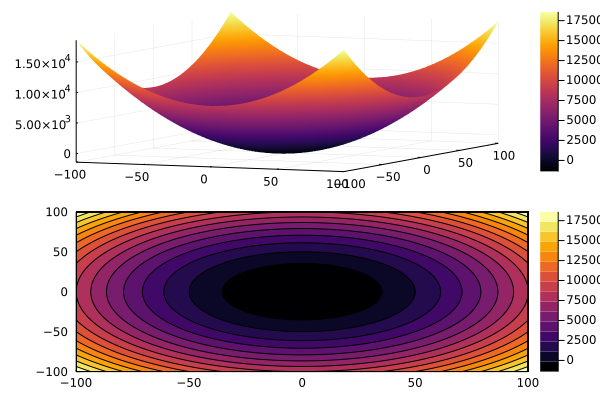

In [50]:
# Sphere Function

f1a = -1400
f1(X) = sum((X).^2) + f1a

x = range(-100,100, length=200)
y = range(-100,100, length=200)
xy = map(x->collect(x), Iterators.product(x,y))
z = f1.(xy)

s = surface(x,y,z)
c = contour(x,y,z, fill=true)
plot(s, c; layout=(2,1))

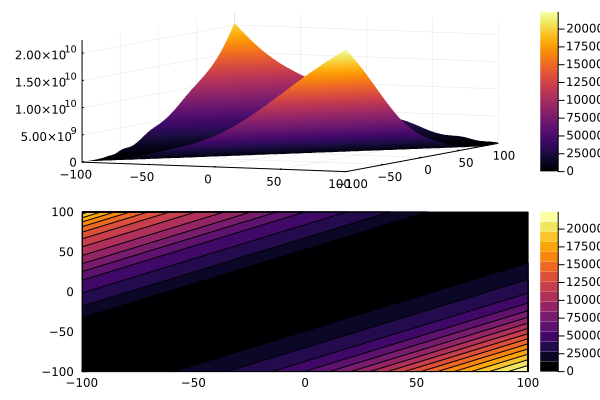

In [51]:
# Rotated High Conditioned Elliptic Function

f2a = -1300

function f2(X)
    r = 0
    D = length(X)
    Z = Tosz(M(1)*(X))
    i = 1:D
    sum(1e6.^((i.-1)./(D.-1)).*Z.^2) .+ f2a
end

z = f2.(xy)

s = surface(x,y,z)
c = contour(x,y,z; fill=true)
plot(s, c; layout=(2,1))

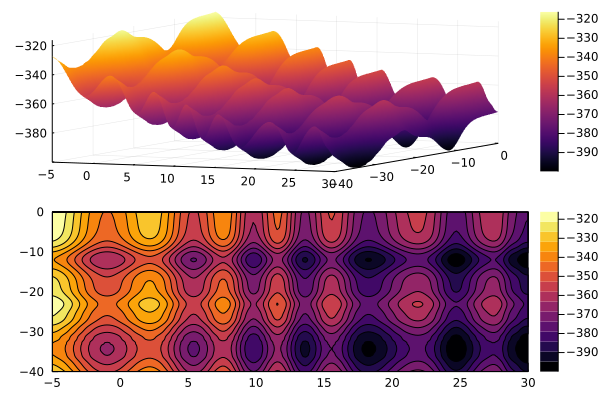

In [52]:
# Rastringin function

f11a = -400

function f11(X)
    D = length(X)
    Z = Α(10, D) * Tasz(Tosz(5.12.*X./100), 0.2)
    sum(Z.^2 .- 10cos.(2π*Z) .+ 10) .+ f11a
end


x = range(-5,30, length=200)
y = range(-40,0, length=200)
xy = map(x->collect(x), Iterators.product(x,y))
z = f11.(xy)

s = surface(x,y,z;)
c = contour(x,y,z; fill=true)
plot(s, c; layout=(2,1))